# LLM usage in PubMed abstracts via excess vocabulary usage

In [1]:
%matplotlib notebook

import numpy as np
import pandas as pd
import pylab as plt

plt.style.use('mpl_style.txt')

from sklearn.neighbors import NearestNeighbors

df = pd.read_parquet("../results/df_tsne_22_24.parquet.gzip")

df

PMID                                              Title  Year  \
0        17111134  Fabrication and application of carbohydrate mi...  2023   
1        17245552  Molecular cloning and characterization of a cy...  2023   
2        20960239  Novel Cellulase Screening and Optimal Producti...  2024   
3        21028883  Pulse Radiolysis Studies of Temperature Depend...  2022   
4        21544554  Identification and Characterization of a Tryps...  2024   
...           ...                                                ...   ...   
4109075  39775769  How do machine learning models perform in the ...  2024   
4109076  39775770  Use of text messages to promote medication adh...  2024   
4109077  39775771  Comparison of the audit method and secondary d...  2024   
4109078  39775773  Challenges in preventing unions and pregnancie...  2024   
4109079  39775791  Genome-wide association neural networks identi...  2024   

                                        Journal          Labels  \
0        Applied microbiology and biotechnology    microbiology   
1                     Molecular biology reports       unlabeled   
2        Applied biochemistry and biotechnology    biochemistry   
3                                  Biochemistry    biochemistry   
4        Applied biochemistry and biotechnology    biochemistry   
...                                         ...             ...   
4109075               Cadernos de saude publica       unlabeled   
4109076               Cadernos de saude publica       unlabeled   
4109077               Cadernos de saude publica       unlabeled   
4109078               Cadernos de saude publica       unlabeled   
4109079             Briefings in bioinformatics  bioinformatics   

              Countries          x          y  contains_rare  contains_common  \
0                 China -41.336465  14.301695          False            False   
1                 China -30.471647  21.530552          False            False   
2                 China -61.087884  31.224746          False             True   
3               Denmark -52.883743  36.074506           True            False   
4                 China -61.388757  32.332601          False             True   
...                 ...        ...        ...            ...              ...   
4109075         unknown  27.774883 -34.785161           True             True   
4109076         unknown  48.281037 -26.564242          False            False   
4109077         unknown  42.309345 -23.760660           True             True   
4109078         unknown  43.464516 -78.062750          False            False   
4109079  United Kingdom  11.631109   8.976822           True            False   

        colors_class colors_country  is_retracted  
0            #B79762        #d21820         False  
1          lightgrey        #d21820         False  
2            #b65141        #d21820         False  
3            #b65141        #474747         False  
4            #b65141        #d21820         False  
...              ...            ...           ...  
4109075    lightgrey      lightgrey         False  
4109076    lightgrey      lightgrey         False  
4109077    lightgrey      lightgrey         False  
4109078    lightgrey      lightgrey         False  
4109079      #FF4A46        #f36dff         False  

[4109080 rows x 13 columns]

In [2]:
X = df[["x", "y"]].values
year = df.Year.values
rare = df.contains_rare.values
common = df.contains_common.values

randperm = np.random.permutation(len(df))

nn = NearestNeighbors(n_neighbors=101)
batch = len(df) // 10 + 1

In [3]:
%%time

nn.fit(X[year == 2022])
NN22 = []
for i in range(10):
    print('.', end='', flush=True)
    NN = nn.kneighbors(X[i * batch : (i + 1) * batch], return_distance=False)
    NN22.append(NN[:, 1:])
NN22 = np.concatenate(NN22)

rare_fr_22 = rare[year == 2022][NN22].mean(axis=1)
common_fr_22 = common[year == 2022][NN22].mean(axis=1)

rare_fr_22_permuted = rare[randperm][year == 2022][NN22].mean(axis=1)
common_fr_22_permuted = common[randperm][year == 2022][NN22].mean(axis=1)

NN22 = []

..........CPU times: user 2min 14s, sys: 13.1 s, total: 2min 27s
Wall time: 2min 27s


In [4]:
%%time

nn.fit(X[year == 2024])
NN24 = []
for i in range(10):
    print('.', end='', flush=True)
    NN = nn.kneighbors(X[i * batch : (i + 1) * batch], return_distance=False)
    NN24.append(NN[:, 1:])
NN24 = np.concatenate(NN24)

rare_fr_24 = rare[year == 2024][NN24].mean(axis=1)
common_fr_24 = common[year == 2024][NN24].mean(axis=1)

rare_fr_24_permuted = rare[randperm][year == 2024][NN24].mean(axis=1)
common_fr_24_permuted = common[randperm][year == 2024][NN24].mean(axis=1)

NN24 = []

..........CPU times: user 2min 17s, sys: 13.7 s, total: 2min 30s
Wall time: 2min 30s


In [5]:
delta_rare = rare_fr_24 - rare_fr_22
delta_common = common_fr_24 - common_fr_22
delta = (delta_rare + delta_common) / 2

delta_rare_permuted = rare_fr_24_permuted - rare_fr_22_permuted
delta_common_permuted = common_fr_24_permuted - common_fr_22_permuted
delta_permuted = (delta_rare_permuted + delta_common_permuted) / 2

np.save(open("delta.npy", "wb"), delta)
np.save(open("delta_permuted.npy", "wb"), delta_permuted)

In [3]:
delta = np.load(open("delta.npy", "rb"))
delta_permuted = np.load(open("delta_permuted.npy", "rb"))

<IPython.core.display.Javascript object>


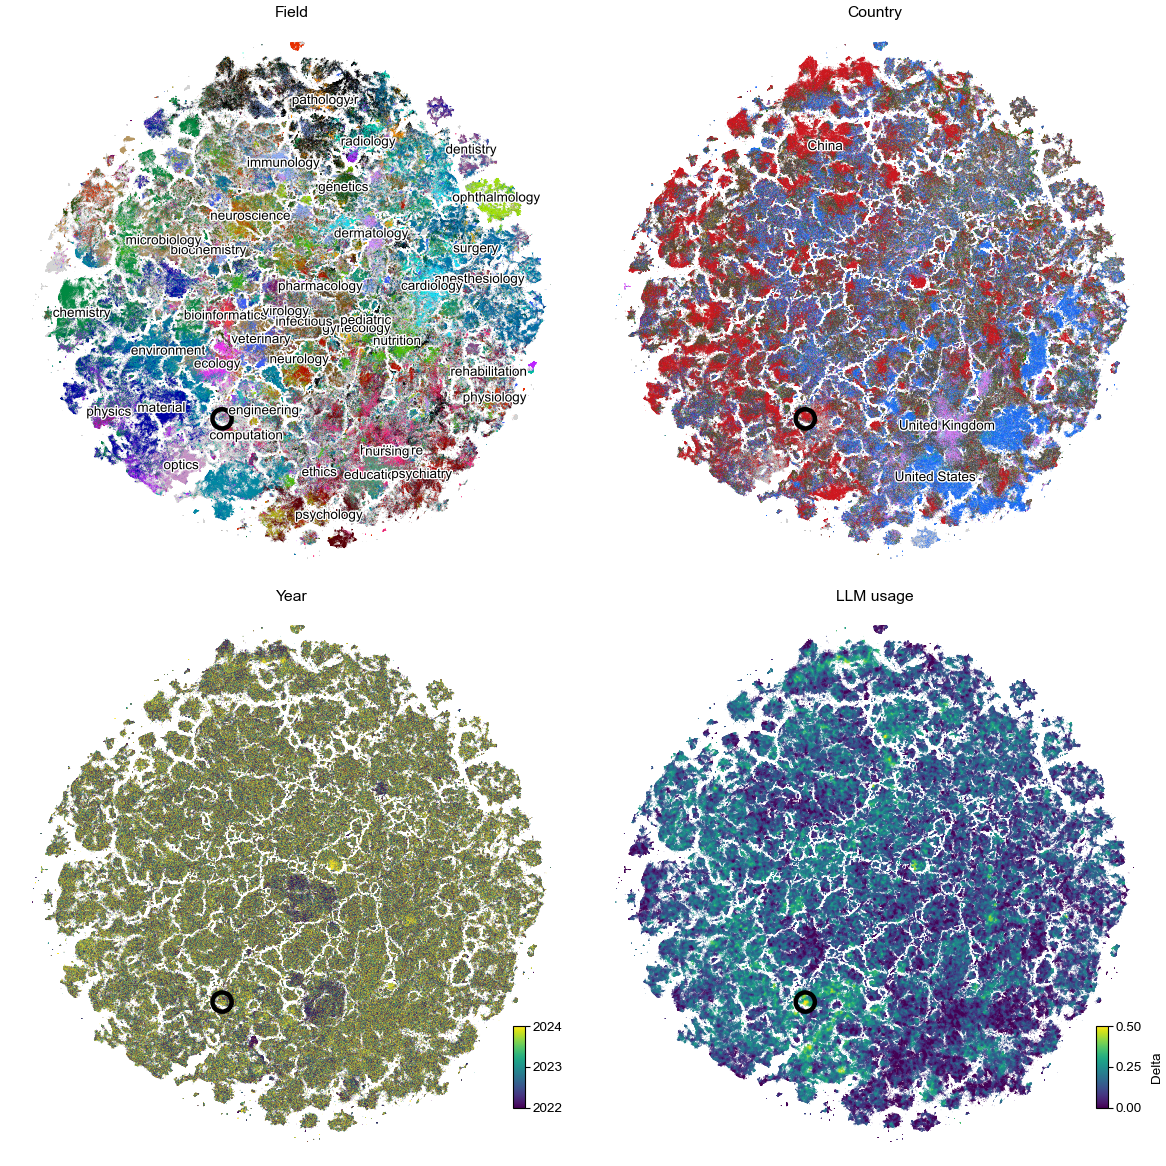

In [4]:
subset = np.random.random(size=len(df)) < 2 # all

plt.figure(figsize=(7.2, 7.2))

s = .2

from matplotlib.patches import Circle
def add_circle():
    circ = Circle((-30.5, -49), 4, ec='black', fc='none', lw=2)
    plt.gca().add_patch(circ)

plt.subplot(221)
plt.axis("equal")
ind = subset & (df.Labels == 'unlabeled')
plt.scatter(df[ind].x, df[ind].y, c=df[ind].colors_class, s=s, ec="none", rasterized=True)
ind = subset & (df.Labels != 'unlabeled')
plt.scatter(df[ind].x, df[ind].y, c=df[ind].colors_class, s=s, ec="none", rasterized=True)
plt.title('Field')
plt.axis('off')
add_circle()

from sklearn.neighbors import KernelDensity
from matplotlib.patheffects import withStroke
subset_kde = np.random.random(size=len(df)) < .01

for label in np.unique(df.Labels):
    if label == "unlabeled":
        continue

    ind = subset_kde & (label == df.Labels)
    Z = df[["x", "y"]].values[ind]
    kde = KernelDensity(kernel="gaussian", bandwidth=10).fit(Z)
    log_density = kde.score_samples(Z)
    mode = Z[np.argmax(log_density)]
    plt.text(
        mode[0],
        mode[1],
        label,
        ha="center",
        va="center",
        c="k",
        fontsize=6,
        path_effects=[withStroke(linewidth=1.2, foreground="white")]
    )

plt.subplot(222)
plt.axis("equal")
ind = subset & (df.Countries == 'unlabeled')
plt.scatter(df[ind].x, df[ind].y, c=df[ind].colors_country, s=s, ec="none", rasterized=True)
ind = subset & (df.Countries != 'unlabeled')
plt.scatter(df[ind].x, df[ind].y, c=df[ind].colors_country, s=s, ec="none", rasterized=True)
plt.title('Country')
plt.axis('off')
add_circle()

subset_kde = np.random.random(size=len(df)) < .01

for label in ['China', 'United Kingdom', 'United States']:
    ind = subset_kde & (label == df.Countries)
    Z = df[["x", "y"]].values[ind]
    kde = KernelDensity(kernel="gaussian", bandwidth=10).fit(Z)
    log_density = kde.score_samples(Z)
    mode = Z[np.argmax(log_density)]
    plt.text(
        mode[0],
        mode[1],
        label,
        ha="center",
        va="center",
        c="k",
        fontsize=6,
        path_effects=[withStroke(linewidth=1.2, foreground="white")]
    )

plt.subplot(223)
plt.axis("equal")
reorder = np.random.permutation(np.sum(subset))
plt.scatter(df.x.values[subset][reorder], df.y.values[subset][reorder], 
            c=year[subset][reorder], s=s, ec="none", vmin=2022, vmax=2024, 
            cmap="viridis", rasterized=True)
plt.title('Year')
plt.axis('off')
add_circle()

cax = plt.axes([.44, .05, .01, .07])
plt.colorbar(cax=cax, ticks=[2022, 2023, 2024])

plt.subplot(224)
plt.axis("equal")
plt.scatter(df.x.values[subset], df.y.values[subset], c=delta[subset], 
            s=s, ec="none", vmin=0, vmax=.5, cmap="viridis", rasterized=True)
plt.title('LLM usage')
plt.axis('off')
add_circle()

cax = plt.axes([.94, .05, .01, .07])
plt.colorbar(label="Delta", cax=cax, ticks=[0, .25, .5])

plt.savefig('../figures/tsne.png', dpi=300)
plt.savefig('../figures/tsne.pdf')

<IPython.core.display.Javascript object>


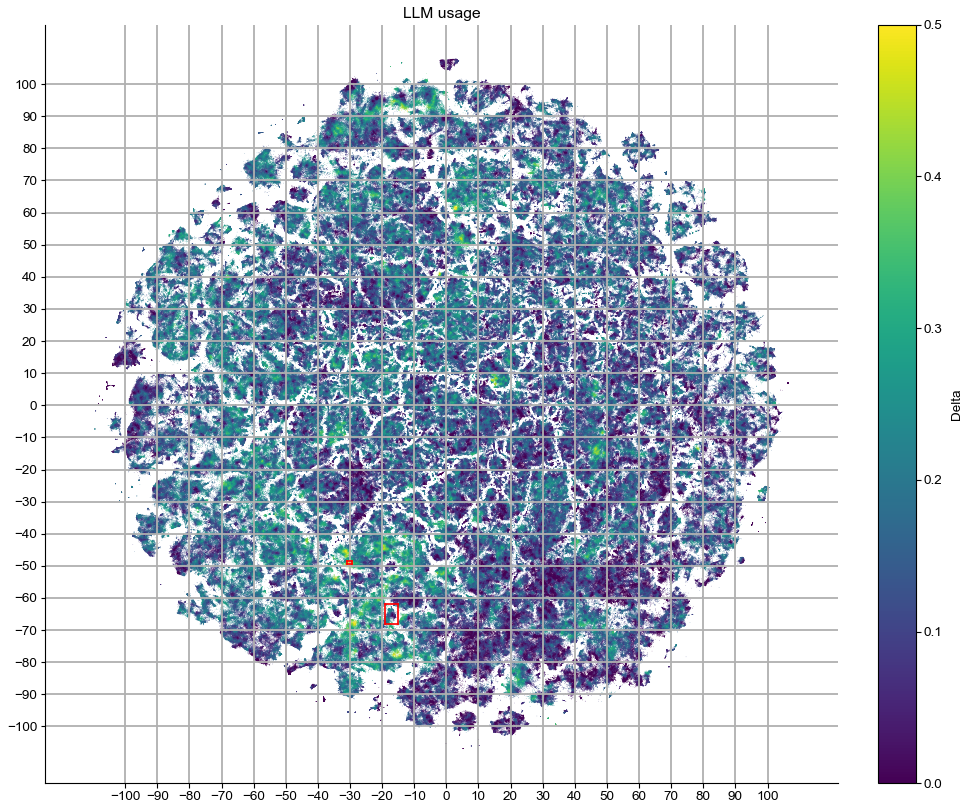

Total papers: 403
Retracted papers: 0.5%
Delta: 0.50
Fraction 2022: 0.20
Fraction 2024: 0.50
['detection' 'based' 'improved' 'algorithm' 'network' 'model' 'method'
 'learning' 'lightweight' 'deep' 'object' 'using' 'recognition' 'images'
 'with' 'attention' 'neural' 'traffic' 'image' 'real-time']
China 83.4%
unknown 3.7%
South Korea 3.2%
India 1.7%
Taiwan 1.2%
Sensors (Basel, Switzerland) 56.3%
Scientific reports 11.9%
PloS one 4.0%
Heliyon 3.0%
PeerJ. Computer science 3.0%
Frontiers in neurorobotics 2.7%
Entropy (Basel, Switzerland) 2.2%
Computational intelligence and neuroscience 2.2%
Mathematical biosciences and engineering : MBE 2.2%
Marine pollution bulletin 1.5%

Total papers: 2841
Retracted papers: 28.8%
Delta: 0.16
Fraction 2022: 0.73
Fraction 2024: 0.12
['based' 'analysis' 'model' 'learning' 'data' 'system' 'education'
 'network' 'teaching' 'deep' 'application' 'design' 'technology' 'neural'
 'algorithm' 'research' 'health' 'under' 'college' 'using']
China 79.9%
South Korea 2.6

In [6]:
plt.figure(figsize=(6, 5))
plt.axis("equal")
plt.scatter(df.x.values, df.y.values, c=delta, s=.2, ec="none", 
            vmin=0, vmax=.5, cmap="viridis", rasterized=True)
plt.colorbar(label="Delta")
plt.title('LLM usage')

plt.grid(True)
plt.xticks(np.arange(-100, 101, 10));
plt.yticks(np.arange(-100, 101, 10));

for bbox in [
    [-31, -29.5, -49.5, -48.5],        
    [-19, -15, -68, -62]
]:
    plt.plot([bbox[0], bbox[1]], [bbox[2], bbox[2]], 'r')
    plt.plot([bbox[0], bbox[1]], [bbox[3], bbox[3]], 'r')
    plt.plot([bbox[0], bbox[0]], [bbox[2], bbox[3]], 'r')
    plt.plot([bbox[1], bbox[1]], [bbox[2], bbox[3]], 'r')
    
    ind = (df.x > bbox[0]) & (df.x < bbox[1]) & (df.y > bbox[2]) & (df.y < bbox[3]) # & df.is_retracted
    ind = ind.values
    print(f"Total papers: {np.sum(ind)}")
    print(f"Retracted papers: {np.mean(df.is_retracted.values[ind]):.1%}")
    print(f"Delta: {np.mean(delta[ind]):.2f}")
    print(f"Fraction 2022: {np.mean(df.Year.values[ind] == 2022):.2f}")
    print(f"Fraction 2024: {np.mean(df.Year.values[ind] == 2024):.2f}")

    w, c = np.unique(
        ' '.join(list(df.Title.values[ind])).lower()
        .replace('.', '').replace(',', '').replace(':', '').split(), 
        return_counts=True)
    l = np.array([len(ww) for ww in w])
    w = w[l > 3]
    c = c[l > 3]
    print(w[np.argsort(c)][::-1][:20])
    
    w, c = np.unique(df.Countries[ind], return_counts=True)
    order = np.argsort(c)[::-1]
    for country, count in zip(w[order][:5], c[order][:5]):
        print(country, f'{count / np.sum(ind):.1%}')
        
    w, c = np.unique(df.Journal[ind], return_counts=True)
    order = np.argsort(c)[::-1]
    for country, count in zip(w[order][:10], c[order][:10]):
        print(country, f'{count / np.sum(ind):.1%}')
        
#     print(df.Journal.values[ind][:100])
    
    print('')